In [1]:
from thesispy.experiments.wandb_client import *
from thesispy.experiments.validation import VALIDATION_NAMES, VALIDATION_ABBRVS
from thesispy.plot_utils import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import numpy as np

In [3]:
ds = get_runs_as_dataset("synthetic_1_fair_comparison_multiresolution")
arrs = ds.aggregate_for_plot(["Optimizer", "MeshSize"], resolution=2)

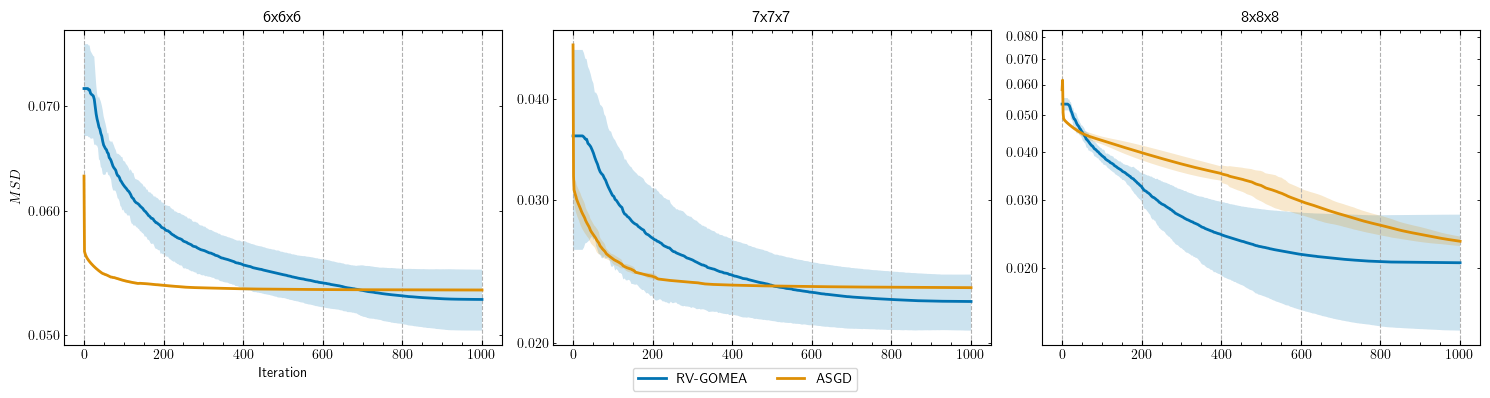

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

for optimizer in ["GOMEA", "AdaptiveStochasticGradientDescent"]:
    for i, mesh_size in enumerate([(3, 3, 3), (4, 4, 4), (5, 5, 5)]):
        arr_avg, arr_std = arrs[(optimizer, mesh_size)]
        xs = np.linspace(0, 1000, len(arr_avg))
        label = "RV-GOMEA" if optimizer == "GOMEA" else "ASGD"
        axes[i].plot(xs, arr_avg, label=label)
        axes[i].fill_between(xs, arr_avg - arr_std, arr_avg + arr_std, alpha=0.2)
        
        # formatting
        axes[i].set_yscale("log")
        axes[i].yaxis.set_major_formatter(ScalarFormatter())
        axes[i].yaxis.set_minor_formatter(ScalarFormatter())
        axes[i].set_title(mesh_size_as_str(mesh_size), loc="center")


axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("$MSD$")
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc="lower center")

plt.tight_layout()
plt.savefig("fair_comparison_mr.png")

In [4]:
df = ds.aggregate(["Optimizer", "MeshSize"], metrics=VALIDATION_NAMES, val=True)

In [6]:
from tabulate import tabulate

rows = []

for i, metric in enumerate(VALIDATION_NAMES):
    row = []
    row.append(VALIDATION_ABBRVS[i])
    for mesh_size in ["(3, 3, 3)", "(4, 4, 4)", "(5, 5, 5)"]:
        df_gomea = df.loc[(df.MeshSize == mesh_size) & (df.Optimizer == "GOMEA")][metric]
        avg_gomea = df_gomea.mean()
        std_gomea = df_gomea.std()

        df_asgd = df.loc[(df.MeshSize == mesh_size) & (df.Optimizer == "AdaptiveStochasticGradientDescent")][metric]
        avg_asgd = df_asgd.mean()
        std_asgd = df_asgd.std() * 2.0
        
        gomea_better = avg_gomea < avg_asgd if metric != "dice_similarity" else avg_gomea > avg_asgd
        if gomea_better:
            row.append(f"\\textbf{{{avg_gomea:.2f}}} ± {std_gomea:.2f}")
            row.append(f"{avg_asgd:.2f} ± {std_asgd:.2f}")
        else:
            row.append(f"{avg_gomea:.2f} ± {std_gomea:.2f}")
            row.append(f"\\textbf{{{avg_asgd:.2f}}} ± {std_asgd:.2f}")

    rows.append(row)

print(tabulate(rows, headers=["c"]*6, tablefmt="latex_raw"))

\begin{tabular}{lllllll}
\hline
                      & c                    & c                    & c           & c                    & c                    & c                    \\
\hline
 $TRE$                & 0.83 ± 0.17          & \textbf{0.44} ± 0.00 & 1.23 ± 0.50 & \textbf{0.25} ± 0.00 & 1.92 ± 0.25          & \textbf{0.68} ± 0.01 \\
 $MSD$                & \textbf{0.34} ± 0.01 & 0.37 ± 0.00          & 0.31 ± 0.02 & \textbf{0.19} ± 0.00 & 0.37 ± 0.01          & \textbf{0.32} ± 0.00 \\
 $HD$                 & 0.79 ± 0.03          & \textbf{0.66} ± 0.00 & 0.76 ± 0.10 & \textbf{0.31} ± 0.00 & 1.10 ± 0.07          & \textbf{1.02} ± 0.03 \\
 $DSC$                & 0.96 ± 0.00          & \textbf{0.97} ± 0.00 & 0.98 ± 0.00 & \textbf{0.99} ± 0.00 & \textbf{0.99} ± 0.00 & 0.98 ± 0.01          \\
 $E_b$                & 0.10 ± 0.01          & \textbf{0.06} ± 0.00 & 0.22 ± 0.16 & \textbf{0.06} ± 0.00 & 3.99 ± 1.65          & \textbf{0.16} ± 0.00 \\
 $\vec{v}_{\epsilon}$ & 0.94 ± 0.12  

In [7]:
ds_nomr = get_runs_as_dataset("synthetic_1_fair_comparison")
ds_mr = get_runs_as_dataset("synthetic_1_fair_comparison_multiresolution")

In [10]:
df_nomr = ds_nomr.aggregate(["Optimizer", "MeshSize"], metrics=["metric"], val=True)
df_mr = ds_mr.aggregate(["Optimizer", "MeshSize"], metrics=["metric"], val=True)

In [26]:
rows = []

for optimizer in ["GOMEA", "AdaptiveStochasticGradientDescent"]:
    row = []
    row.append("RV-GOMEA" if optimizer == "GOMEA" else "ASGD")
    for mesh_size in ["(3, 3, 3)", "(4, 4, 4)", "(5, 5, 5)"]:
        df_nomr_opt = df_nomr.loc[(df_nomr.MeshSize == mesh_size) & (df_nomr.Optimizer == optimizer)]["metric"]
        avg_nomr_opt = df_nomr_opt.mean()
        std_nomr_opt = df_nomr_opt.std()

        df_mr_opt = df_mr.loc[(df_mr.MeshSize == mesh_size) & (df_mr.Optimizer == optimizer)]["metric"]
        avg_mr_opt = df_mr_opt.mean()
        std_mr_opt = df_mr_opt.std() * 2.0

        mr_better = avg_mr_opt < avg_nomr_opt
        if mr_better:
            row.append(f"{avg_nomr_opt:.3f} ± {std_nomr_opt:.3f}")
            row.append(f"\\textbf{{{avg_mr_opt:.3f}}} ± {std_mr_opt:.3f}")

        else:
            row.append(f"\\textbf{{{avg_nomr_opt:.3f}}} ± {std_nomr_opt:.3f}")
            row.append(f"{avg_mr_opt:.3f} ± {std_mr_opt:.3f}")
    rows.append(row)

print(tabulate(rows, headers=["c"]*6, tablefmt="latex_raw"))

\begin{tabular}{lllllll}
\hline
          & c            & c                     & c            & c                     & c            & c                     \\
\hline
 RV-GOMEA & 0.12 ± 0.002 & \textbf{0.05} ± 0.002 & 0.06 ± 0.001 & \textbf{0.02} ± 0.002 & 0.07 ± 0.004 & \textbf{0.02} ± 0.007 \\
 ASGD     & 0.13 ± 0.000 & \textbf{0.05} ± 0.000 & 0.07 ± 0.002 & \textbf{0.02} ± 0.000 & 0.11 ± 0.000 & \textbf{0.02} ± 0.001 \\
\hline
\end{tabular}


In [23]:
x = df_mr.loc[(df_mr.MeshSize == "(5, 5, 5)") & (df_mr.Optimizer == "GOMEA")]["metric"].values

In [ ]:
df_mr.loc[(df_mr.MeshSize == "(5, 5, 5)") & (df_mr.Optimizer == "GOMEA")]["metric"]

In [22]:
from scipy.stats import sem

In [25]:
sem(x)

0.0011487873335730063